# ДЗ 2
Юсупов Дмитрий, РИ-400024

Импорт требуемых библиотек

In [101]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import shap

from itertools import product
from tqdm import tqdm_notebook
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from lime import lime_tabular

%matplotlib inline

Для анализа был выбран временной ряд данных об осадках `rainfall.csv`

In [102]:
df = pd.read_csv('/home/dvirtuosa/urfu/analyze/4kurs/rainfall.csv', index_col=['date'], parse_dates=['date'])
df

,mean_rainfall
date,
1990-01-01,1.613
1990-01-11,1.557
1990-01-21,2.219
1990-02-01,4.788
1990-02-11,6.510
...,...
2019-11-11,6.737
2019-11-21,5.216
2019-12-01,2.022


Группировка данных по месяцам, вычиление среднего значения для каждого месяца и удаление строк с отсутствующими значениями

In [103]:
df = df.resample('M').mean().dropna()
df

,mean_rainfall
date,
1990-01-31,1.796333
1990-02-28,5.270333
1990-03-31,9.169667
1990-04-30,16.180333
1990-05-31,78.126333
...,...
2019-08-31,174.259000
2019-09-30,83.920000
2019-10-31,44.260333


Визуализация временного ряда

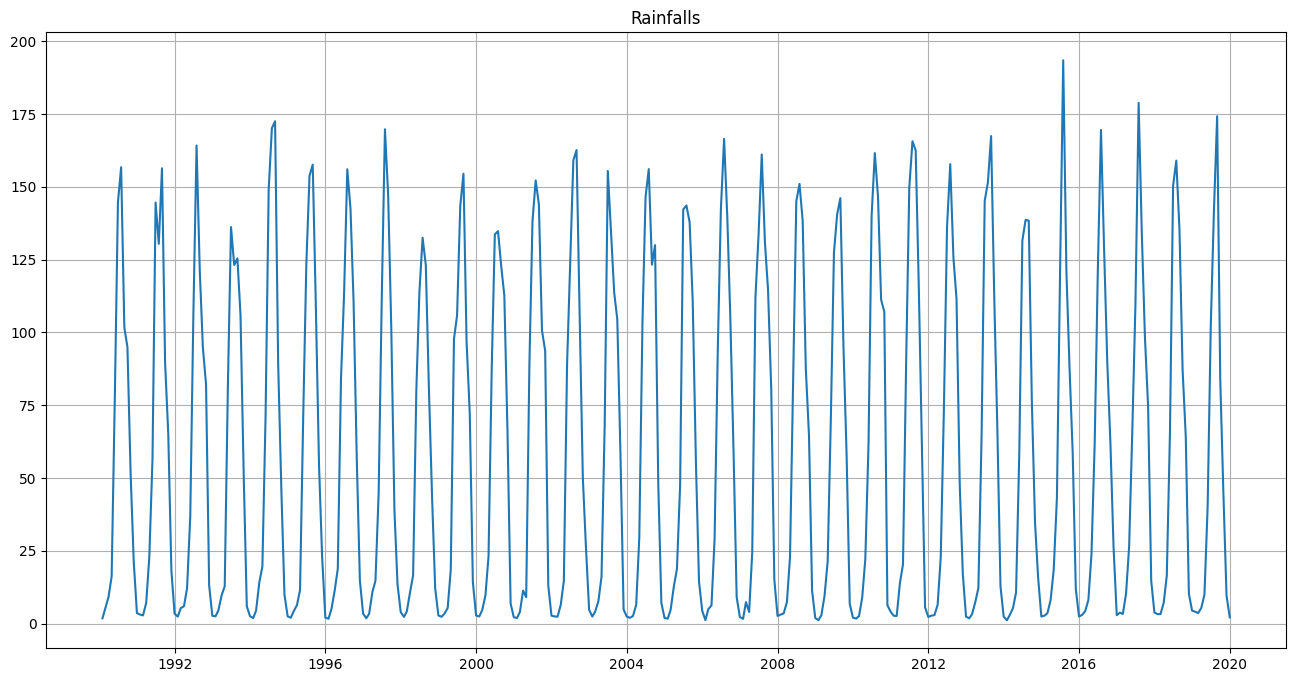

In [104]:
plt.figure(figsize=(16, 8))
plt.plot(df.mean_rainfall)
plt.title('Rainfalls')
plt.grid(True)
plt.show()

Выводы исходя из визуализации:
- наблюдается сезонность (рост осадков в начале каждого года, спад к концу) -> ряд не стационарен;
- тренд не выявлен.

train/test split:

In [105]:
def train_test_split(df, test_size):

    test_index = int(len(df)*(1-test_size))

    df_train = df.iloc[:test_index]
    df_test = df.iloc[test_index:]

    return df_train, df_test


df_train, df_test = train_test_split(df, test_size=0.3)

### Baseline (скользящее среднее):

In [106]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(df_train, 3)

74.88077777777778

In [107]:
df_test.head(1)

,mean_rainfall
date,
2010-12-31,4.079667


Визуализация скользящего среднего по месяцам (окно 4 месяца)

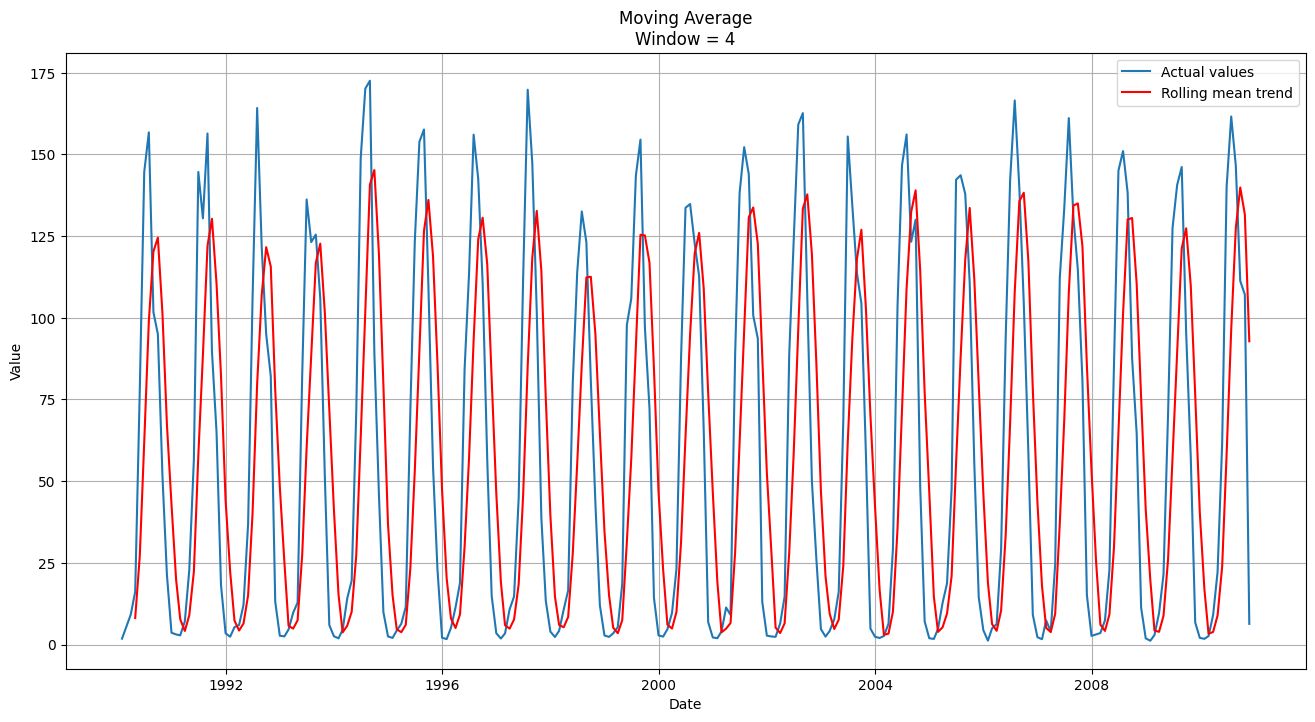

In [108]:
def plot_moving_average(series, window):
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(16, 8))
    plt.plot(series.index, series, label='Actual values')
    plt.plot(rolling_mean.index, rolling_mean, 'r', label='Rolling mean trend')
    plt.title('Moving Average\nWindow = {}'.format(window))
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_moving_average(df_train, 4)

Для замеров качества работы Baseline была рассчитана MAE (mean absolute error)

In [109]:
mean_absolute_error([moving_average(df_train, 4)], df_test.head(1))


88.71700000000001

Ошибка получилась очень большой, так как базовая модель не учитывает многие аспекты временного ряда

### Статистическая модель
Тест Дики-Фуллера

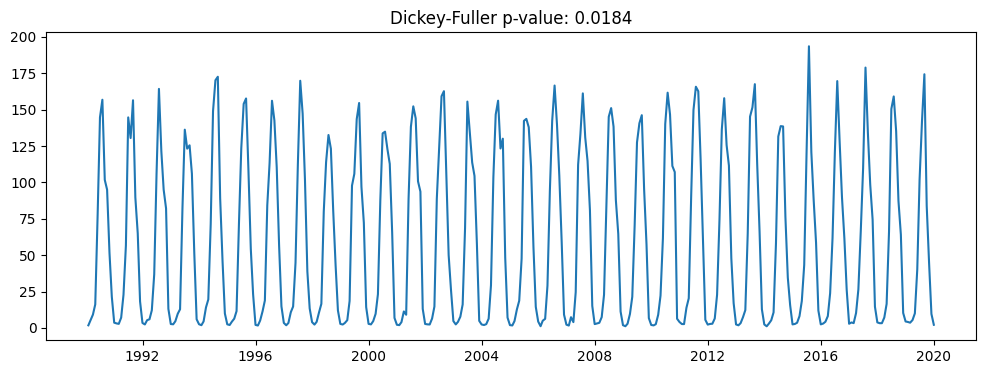

In [110]:
plt.figure(figsize=(12, 4))
plt.plot(df)
plt.title("Dickey-Fuller p-value: {}".format(round(sm.tsa.stattools.adfuller(df_train)[1], 4)))
plt.show()

Значение p - маленькое -> данный тест указывает на стационарность ряда. Однако данный тест не учитывает сезонность.

Построение ACF и PACF

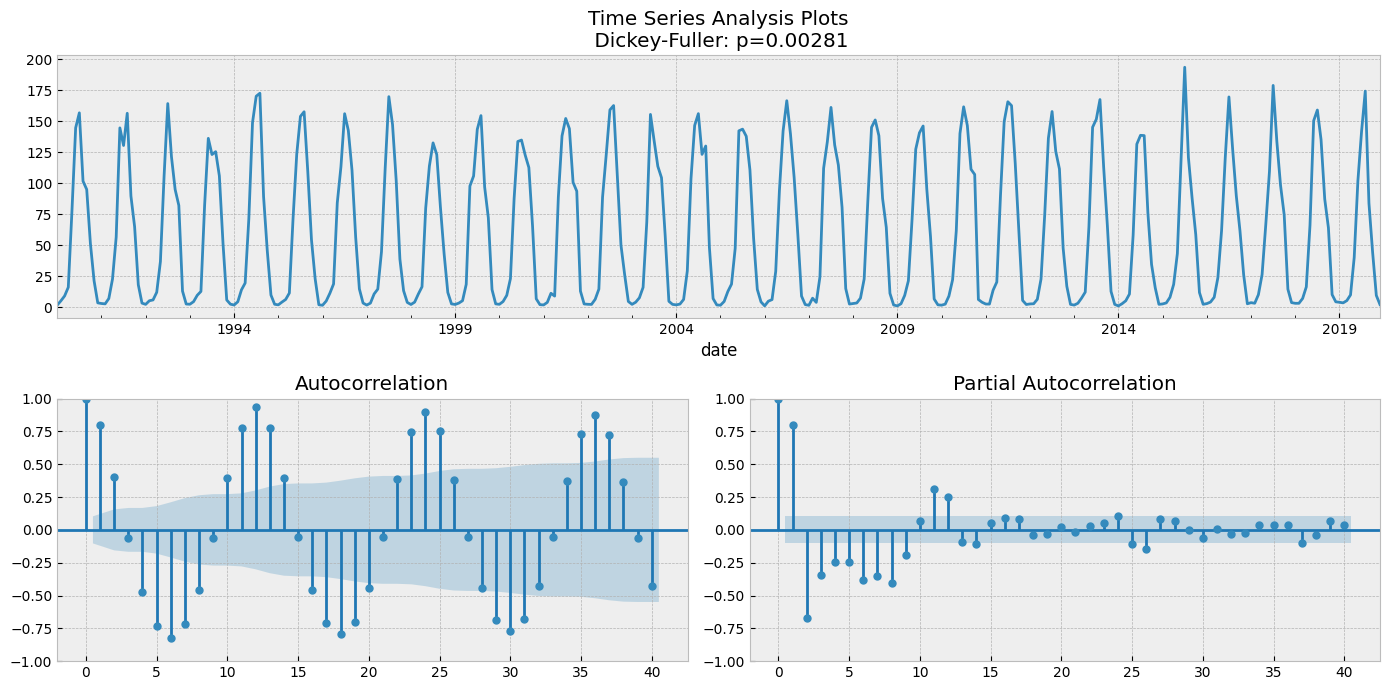

In [111]:
def tsplot(y, lags=None, figsize=(14, 7), style='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

tsplot(df.mean_rainfall, lags=40)

Исходя из графика Autocorrelation - продолжительность сезонности 12 лагов (1 год).
Предположения после первоначальной визуализации подтвердились.


Сезонное дифференцирование (с вычетом сезонных лагов):

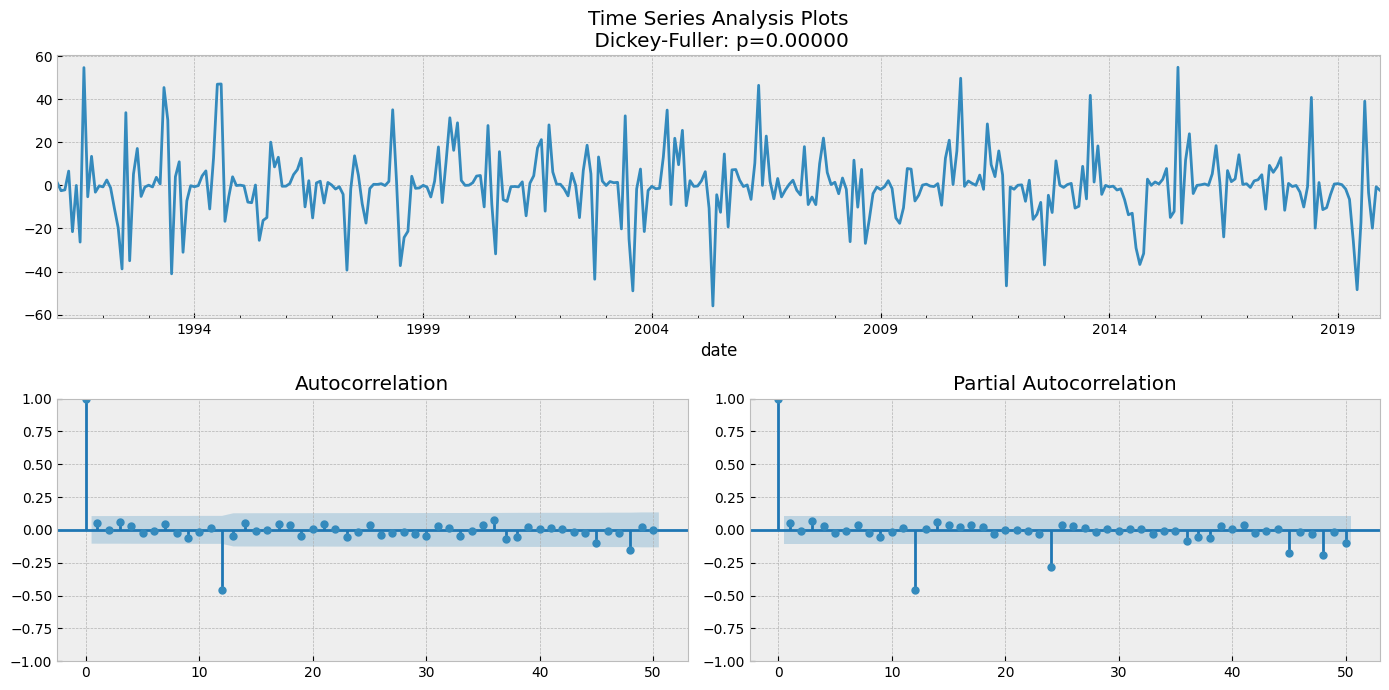

In [112]:
df_diff = df.mean_rainfall - df.mean_rainfall.shift(12)
tsplot(df_diff[12:], lags=50)

Тест указывает на стационарность ряда, при этом 12-й лаг сильно отклоняется от остальных.


Обучение модели SARIMA:

In [113]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(df.mean_rainfall, order=(param[0], d, param[1]),
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

d = 0 #Обычное дифференцирование не выполнялось
D = 1 #Сезонное дифференцирование выполнялось
s = 12 #Период - 12 лагов

#Данные значения были подобраны исходя из ACF и PACF
ps = range(2, 4)
qs = range(2, 4)
Ps = range(0, 2)
Qs = range(2, 3)


parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [114]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)

  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 3min 11s, sys: 15min 46s, total: 18min 58s
Wall time: 1min 22s


In [115]:
result_table.head()

,parameters,aic
0,"(3, 3, 1, 2)",2744.605483
1,"(3, 3, 0, 2)",2744.796058
2,"(3, 2, 1, 2)",2745.711043
3,"(2, 3, 1, 2)",2746.075122
4,"(2, 2, 1, 2)",2749.567323


In [116]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_train, order=(p, d, q),
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                           mean_rainfall   No. Observations:                  251
Model:             SARIMAX(3, 0, 3)x(1, 1, [1, 2], 12)   Log Likelihood                -939.370
Date:                                 Sun, 03 Mar 2024   AIC                           1898.739
Time:                                         19:47:03   BIC                           1933.504
Sample:                                     01-31-1990   HQIC                          1912.749
                                          - 11-30-2010                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4924      0.970      0.507      0.612      -1.409       2

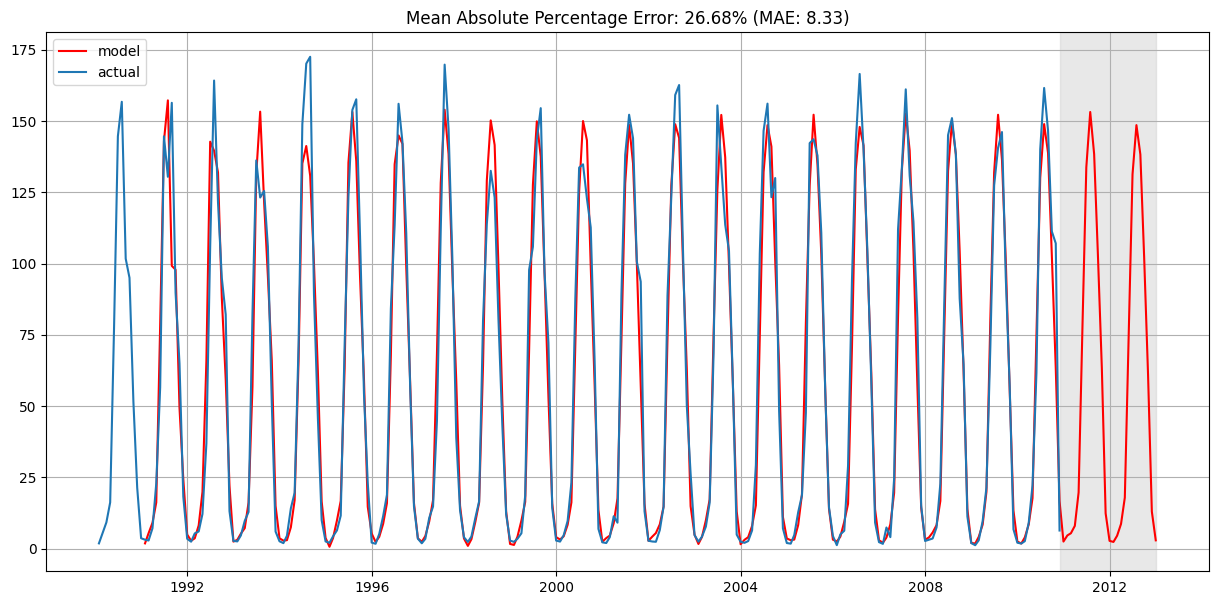

In [117]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def plotSARIMA(series, model, n_steps):

    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN

    # forecasting on n_steps forward
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model._append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error1 = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])
    error2 = mean_absolute_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title(f"Mean Absolute Percentage Error: {round(error1, 2)}% (MAE: {round(error2, 2)})")
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

plotSARIMA(df_train, best_model, 24)

Результаты по сравнению в Baseline улучшились:
- процентаж средней абсолютной ошибки равен ~26.7%;
- средняя абсолютная ошибка составляет ~8.33.

### Классическая модель
Создание 36 (экспериментальным путем - получен самый лучший результат) признаков под лаги одного цикла (под сезонность временного ряда):

In [118]:
data = pd.DataFrame(df.mean_rainfall.copy())
data.columns = ["y"]

for i in range(1, 37):
    data["lag_{}".format(i)] = data.y.shift(i)

Создание признаков дня и месяца (так как основными признаками являются именно эти признаки):

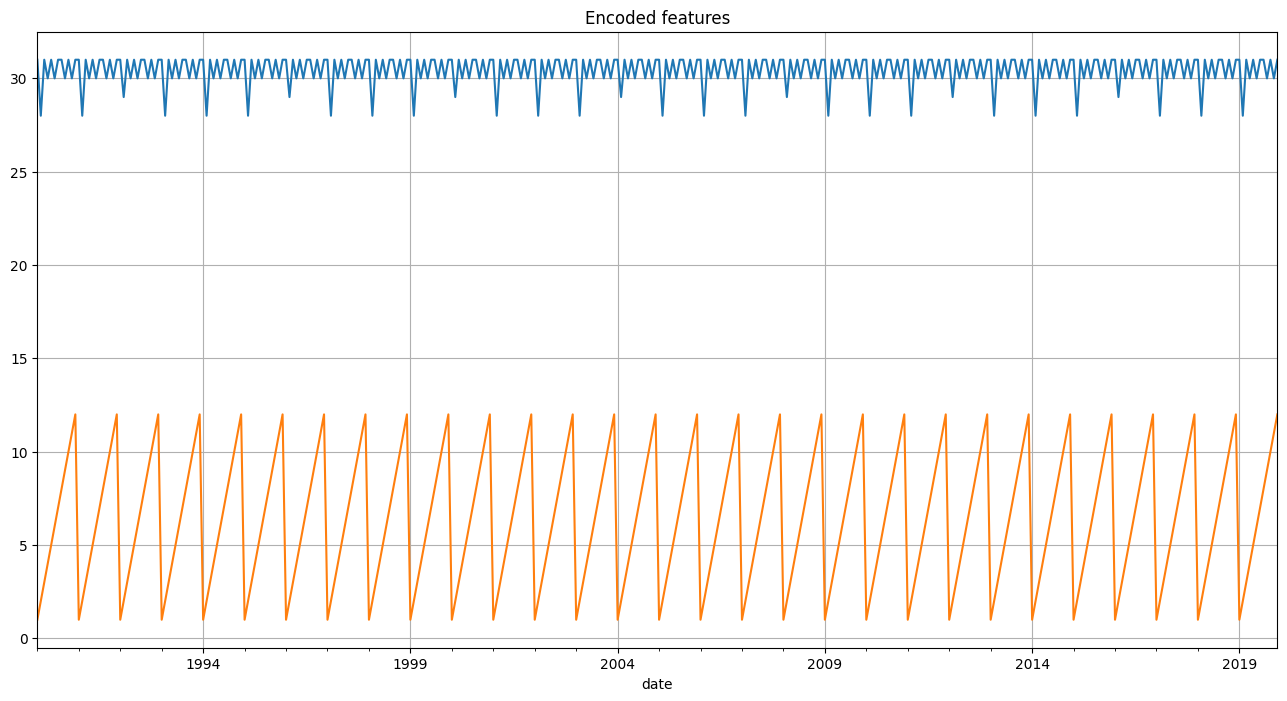

In [119]:
data['day'] = data.index.day
data['month'] = data.index.month
plt.figure(figsize=(16, 8))
plt.title("Encoded features")
data.day.plot()
data.month.plot()
#data.year.plot()
plt.grid(True);

### Обучение модели

test/train split

In [120]:
def timeseries_train_test_split(X, y, test_size):

    test_index = int(len(X)*(1-test_size))

    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]

    return X_train, X_test, y_train, y_test

y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [121]:
def plotModelResults(model, X_train=X_train, X_test=X_test):

    prediction = model.predict(X_test)

    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)

    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [122]:
regr = RandomForestRegressor(max_depth=6, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, random_state=42)

### Визуализация полученных результатов

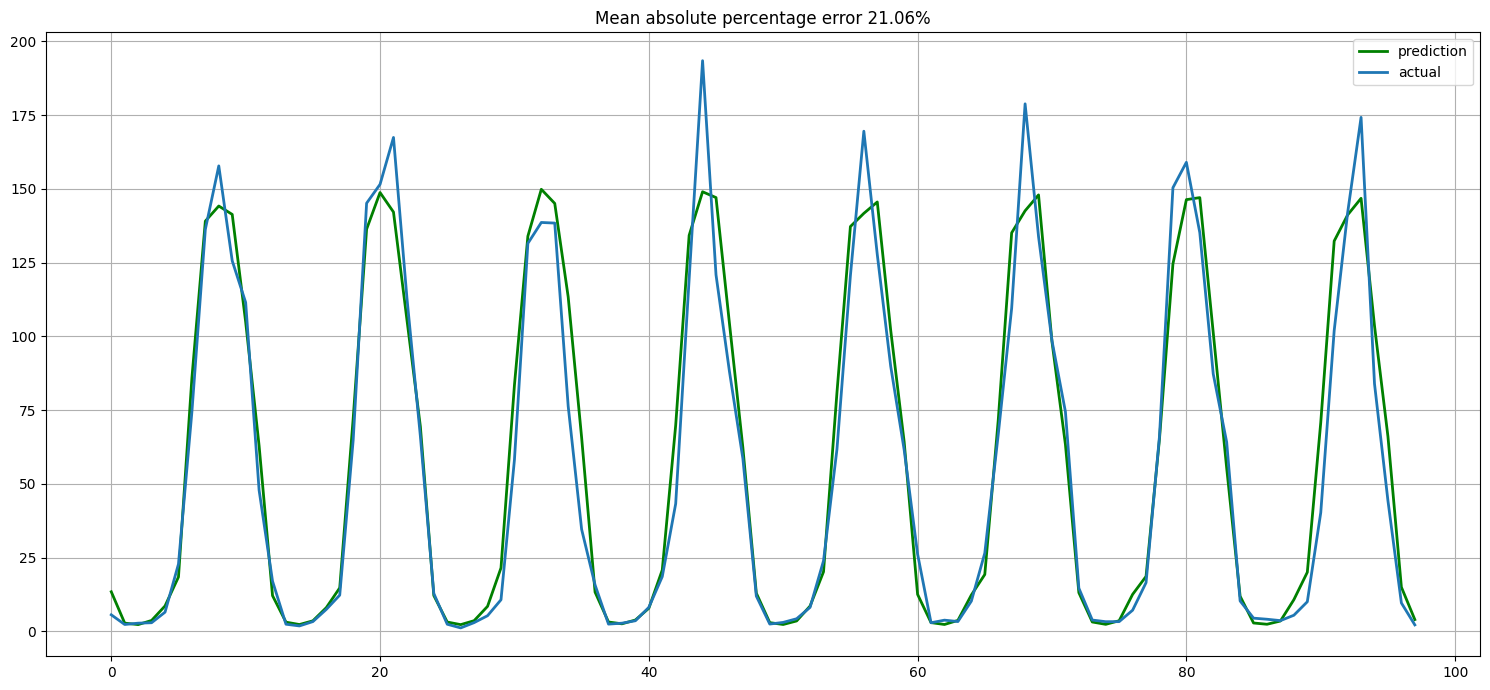

In [123]:
plotModelResults(regr, X_train=X_train, X_test=X_test)

MAE составила ~21.06%, что меньше чем результат SARIMA.

### Интерпретация данных

#### Permutation importance

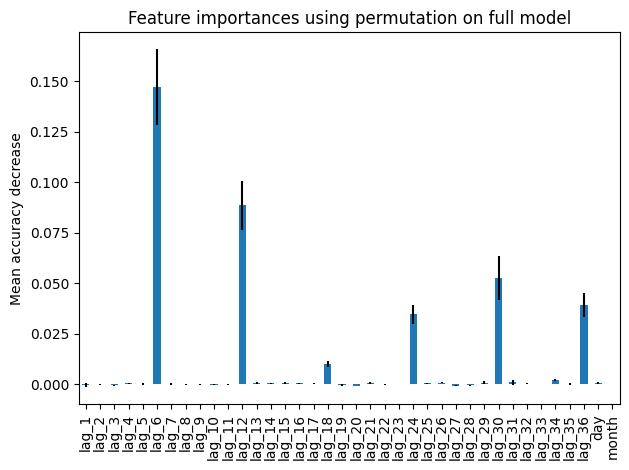

In [124]:
importances = permutation_importance(regr, X_test, y_test, n_repeats=10, random_state=2023, n_jobs=2)
forest_importances = pd.Series(importances.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=importances.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### Lime

In [125]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['rings'],
    verbose=True,
    mode='regression',
)
i = 33
exp = explainer.explain_instance(X_test.iloc[i].values, regr.predict, num_features=5)

Intercept 40.013994347863246
Prediction_local [126.99845025]
Right: 145.07163060270784


In [126]:
exp.show_in_notebook(show_table=True)

In [127]:
exp.as_list()

[('lag_6 <= 4.99', 28.79385838779645),
 ('lag_12 > 112.52', 20.2121503399321),
 ('lag_30 <= 5.14', 13.735295316115463),
 ('lag_36 > 112.01', 12.582723858308547),
 ('lag_24 > 112.52', 11.660428001639255)]

### SHAP (локальная)

In [128]:
explainer = shap.TreeExplainer(regr)

In [129]:
choosen_instance = X_test.iloc[[33]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [130]:
choosen_instance = X_test.iloc[[27]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

### SHAP (глобальная)

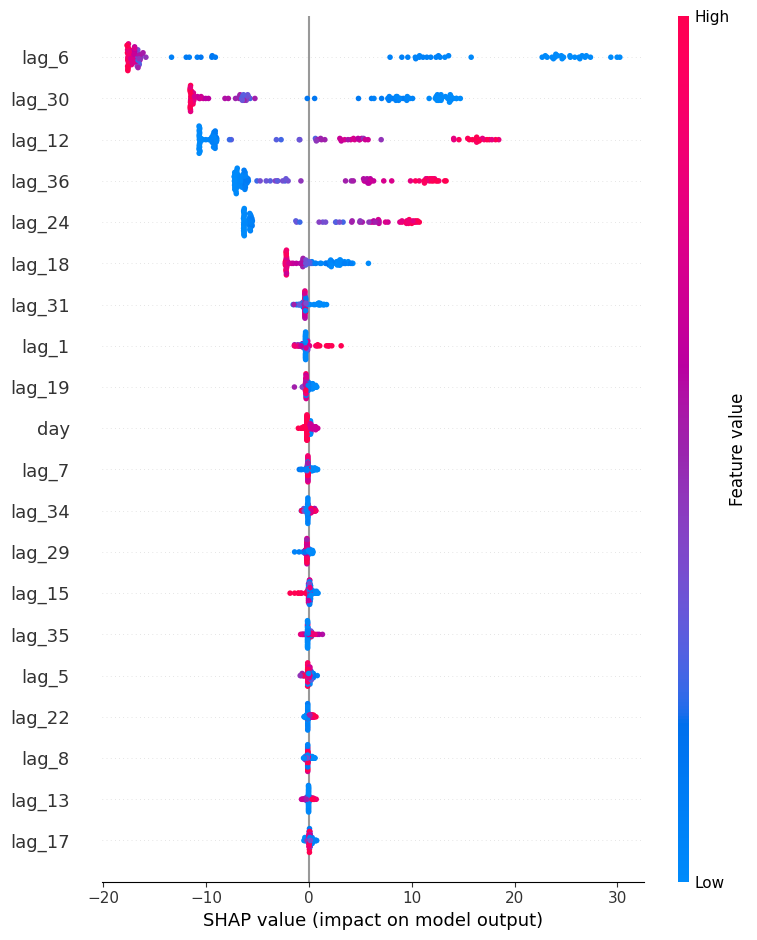

In [131]:
shap_values = explainer.shap_values(X_train.iloc[:100])
shap.summary_plot(shap_values, X_train.iloc[:100])

Исходя из результатов различных интерпретаций можно сделать вывод, что оптимальными лагами для анализа являются значения, являющиеся делителями значения периода (12 лагов) или кратны этому значению - 6, 12, 24, 36.